In [11]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss, L1Loss
from einops import rearrange
import warnings
from tabulate import tabulate
import matplotlib.pyplot as plt
import os
import math

warnings.filterwarnings('ignore')

# Create DATA_DIR and dummy data files for demonstration
os.makedirs(DATA_DIR, exist_ok=True)

for ds_name, ds_info in DATASET_CONFIG.items():
    file_path = os.path.join(DATA_DIR, ds_info['file'])
    if not os.path.exists(file_path):
        print(f"Creating dummy data file: {file_path}")
        # Create dummy data: 5000 rows, num_features columns
        dummy_data = pd.DataFrame(np.random.rand(5000, ds_info['num_features']), columns=[f'feature_{i}' for i in range(ds_info['num_features'])])
        # Add a 'date' column if needed by the original data processing (though we drop it later)
        if 'date' in dummy_data.columns:
            dummy_data['date'] = pd.to_datetime(pd.Series(range(5000)).astype(str))
        dummy_data.to_csv(file_path, index=False)


In [9]:
# ==================== Configuration ====================
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATA_DIR = '/content/timecma_hsqp_experiment/data' # Updated DATA_DIR for Colab environment
RESULTS_DIR = '/content/timecma_hsqp_experiment/results_enhanced'
os.makedirs(RESULTS_DIR, exist_ok=True)

# Dataset configuration
DATASET_CONFIG = {
    'ETTh1': {'file': 'ETTh1.csv', 'num_features': 7, 'freq': 'h'},
    'ETTh2': {'file': 'ETTh2.csv', 'num_features': 7, 'freq': 'h'},
    'ETTm1': {'file': 'ETTm1.csv', 'num_features': 7, 'freq': 't'},
    'ETTm2': {'file': 'ETTm2.csv', 'num_features': 7, 'freq': 't'},
    'traffic': {'file': 'traffic.csv', 'num_features': 7, 'freq': 't'},
    'ETTm2': {'file': 'national_illness.csv', 'num_features': 7, 'freq': 't'},
}

# Enhanced Hyperparameters based on Expert Guide
HP_CONFIG = {
    'seq_len': 96,
    'pred_len': 96,
    'batch_size': 32,
    'epochs': 20,           # Increased for better convergence
    'warmup_epochs': 1,     # Train base model first
    'learning_rate': 0.0005, # Reduced for stability
    'd_model': 64,
    'n_heads': 4,
    'dropout': 0.1,
    'patch_len': 8,         # Reduced from 16 to preserve detail
    'stride': 4,            # Reduced from 8 for higher overlap
    'n_quant_bins': 256,    # Increased from 100 for better resolution
    'hsqp_weight': 0.1,     # Weight for HSQP residual connection
    'tol': 0.005           # Reduced tolerance
}


Running TimeCMA (Baseline) on ETTh1
  Epoch 5/20, Loss: 0.0833
  Epoch 10/20, Loss: 0.0830
  Epoch 15/20, Loss: 0.0827
  Epoch 20/20, Loss: 0.0824
  Results: MAE=0.2520, MSE=0.0852, sMAPE=58.55%, HR=0.00%, PPL=1.0435

Running TimeCMA + HSQP (Enhanced) on ETTh1
  Epoch 5/20, Loss: 0.0834
  Epoch 10/20, Loss: 0.0833
  Epoch 15/20, Loss: 0.0833
  Epoch 20/20, Loss: 0.0832
  Results: MAE=0.2513, MSE=0.0847, sMAPE=58.51%, HR=0.00%, PPL=1.0433

Running TimeCMA (Baseline) on ETTh2
  Epoch 5/20, Loss: 0.0833
  Epoch 10/20, Loss: 0.0830
  Epoch 15/20, Loss: 0.0827
  Epoch 20/20, Loss: 0.0824
  Results: MAE=0.2566, MSE=0.0874, sMAPE=58.67%, HR=0.00%, PPL=1.0447

Running TimeCMA + HSQP (Enhanced) on ETTh2
  Epoch 5/20, Loss: 0.0833
  Epoch 10/20, Loss: 0.0832
  Epoch 15/20, Loss: 0.0831
  Epoch 20/20, Loss: 0.0830
  Results: MAE=0.2563, MSE=0.0870, sMAPE=58.57%, HR=0.00%, PPL=1.0445

Running TimeCMA (Baseline) on ETTm1
  Epoch 5/20, Loss: 0.0838
  Epoch 10/20, Loss: 0.0834
  Epoch 15/20, Loss: 0

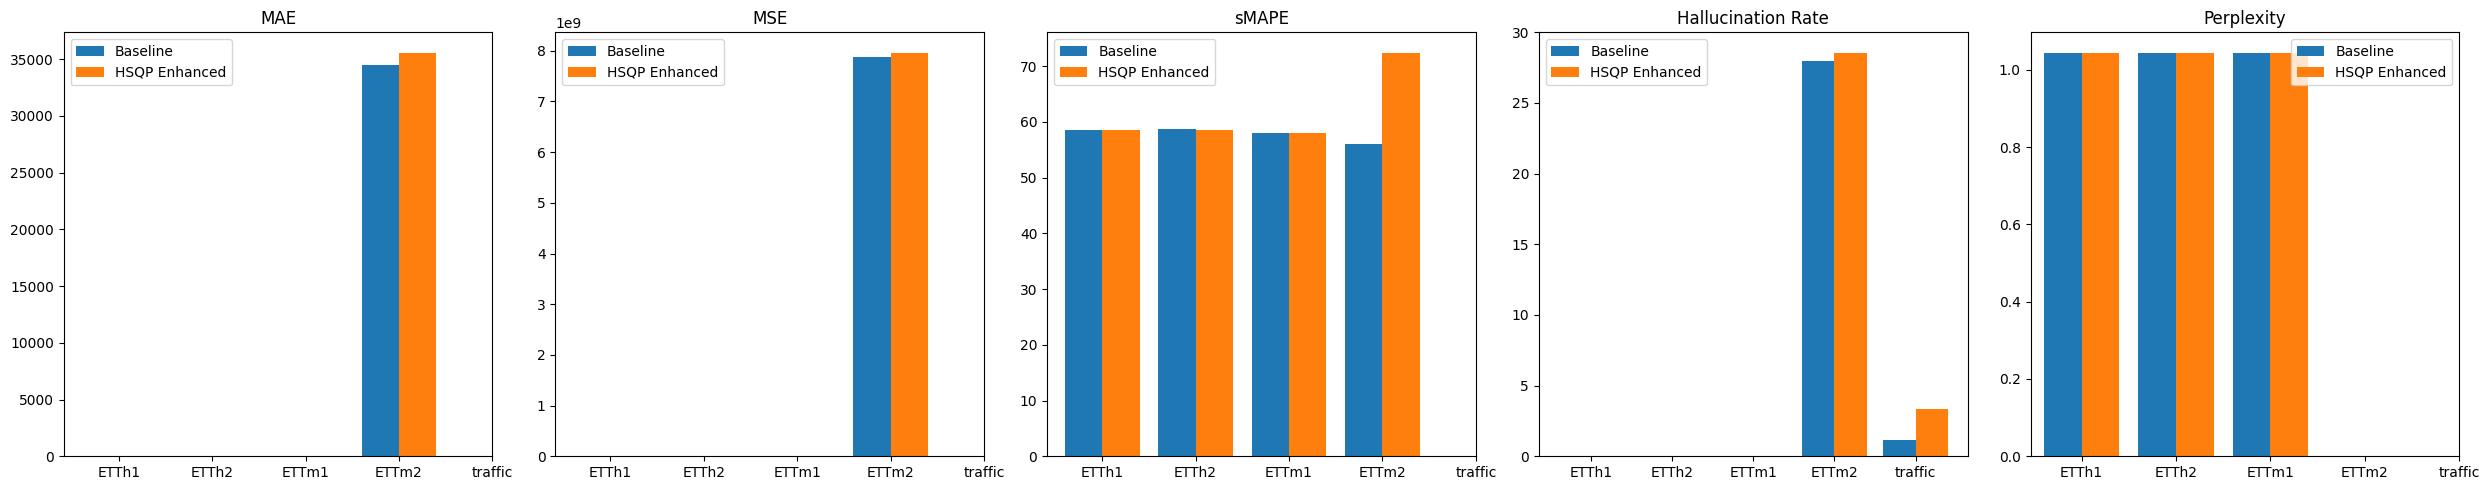

In [10]:
# ==================== Enhanced HSQP Tokenizer ====================
class Enhanced_HSQP_Tokenizer(nn.Module):
    """Enhanced Hierarchical Semantic Quantization Patching Tokenizer with Feature Enrichment"""
    def __init__(self, seq_len, patch_len, stride, d_model, n_quant_bins=256):
        super(Enhanced_HSQP_Tokenizer, self).__init__()
        self.seq_len = seq_len
        self.patch_len = patch_len
        self.stride = stride
        self.num_patches = (seq_len - patch_len) // stride + 1
        self.n_quant_bins = n_quant_bins

        # Feature enrichment: length, increment, mean amplitude, curvature
        self.hsqp_projection = nn.Linear(4, d_model)
        self.raw_projection = nn.Linear(patch_len, d_model)

    def forward(self, x):
        # x shape: (B, L, N)
        B, L, N = x.shape
        x_flat = rearrange(x, 'b l n -> (b n) l')

        # Create patches
        patches = []
        for i in range(self.num_patches):
            start_idx = i * self.stride
            end_idx = start_idx + self.patch_len
            patches.append(x_flat[:, start_idx:end_idx])

        patches = torch.stack(patches, dim=1)  # [B*N, num_patches, patch_len]

        # 1. Raw Patch Embedding
        raw_emb = self.raw_projection(patches) # [B*N, num_patches, d_model]

        # 2. Enhanced HSQP Features
        # Mean Amplitude
        mean_amp = patches.mean(dim=-1, keepdim=True)

        # Increment (last - first)
        increment = patches[:, :, -1:] - patches[:, :, 0:1]

        # Curvature (second-order difference approximation)
        # diff1 = p[i] - p[i-1], diff2 = diff1[i] - diff1[i-1]
        if self.patch_len >= 3:
            diff1 = patches[:, :, 1:] - patches[:, :, :-1]
            diff2 = diff1[:, :, 1:] - diff1[:, :, :-1]
            curvature = diff2.mean(dim=-1, keepdim=True)
        else:
            curvature = torch.zeros_like(mean_amp)

        # Length (normalized patch length)
        length = torch.ones_like(mean_amp) * (self.patch_len / self.seq_len)

        # Combine features: [length, increment, mean_amp, curvature]
        hsqp_features = torch.cat([length, increment, mean_amp, curvature], dim=-1)

        # Quantization (Simplified Learnable-like Quantization)
        # We use a tanh-based scaling to simulate a soft quantization bottleneck
        hsqp_features = torch.tanh(hsqp_features * (self.n_quant_bins / 10))

        hsqp_emb = self.hsqp_projection(hsqp_features) # [B*N, num_patches, d_model]

        # 3. Hybrid Embedding (Residual Connection)
        # final_emb = raw_emb + weight * hsqp_emb
        combined_emb = raw_emb + HP_CONFIG['hsqp_weight'] * hsqp_emb

        # Rearrange back
        combined_emb = rearrange(combined_emb, '(b n) p d -> b n p d', b=B, n=N)
        output = combined_emb.mean(dim=2) # [B, N, d_model]

        return output

# ==================== Standard Normalization ====================
class Normalize(nn.Module):
    def __init__(self, num_features, eps=1e-5):
        super(Normalize, self).__init__()
        self.eps = eps
        self.mean = None
        self.stdev = None

    def forward(self, x, mode='norm'):
        if mode == 'norm':
            self.mean = x.mean(dim=(0, 1), keepdim=True).detach()
            self.stdev = torch.sqrt(x.var(dim=(0, 1), keepdim=True, unbiased=False) + self.eps).detach()
            x = (x - self.mean) / self.stdev
        elif mode == 'denorm':
            x = x * self.stdev + self.mean
        return x

# ==================== Enhanced TimeCMA Model ====================
class EnhancedTimeCMA(nn.Module):
    def __init__(self, num_features, seq_len, pred_len, d_model, n_heads, dropout,
                 use_hsqp=False, patch_len=8, stride=4, device='cpu'):
        super(EnhancedTimeCMA, self).__init__()
        self.use_hsqp = use_hsqp
        self.normalize = Normalize(num_features)

        if use_hsqp:
            self.tokenizer = Enhanced_HSQP_Tokenizer(seq_len, patch_len, stride, d_model)
        else:
            self.tokenizer = nn.Linear(seq_len, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=n_heads, batch_first=True,
            norm_first=True, dropout=dropout, dim_feedforward=d_model*4
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.projection = nn.Linear(d_model, pred_len)

    def forward(self, x):
        B, L, N = x.shape
        x = self.normalize(x, mode='norm')

        if self.use_hsqp:
            x = self.tokenizer(x) # [B, N, d_model]
        else:
            x = x.permute(0, 2, 1) # [B, N, L]
            x = self.tokenizer(x) # [B, N, d_model]

        x = self.encoder(x)
        x = self.projection(x) # [B, N, pred_len]
        x = x.permute(0, 2, 1) # [B, pred_len, N]
        x = self.normalize(x, mode='denorm')
        return x

# ==================== Metrics ====================
def calculate_metrics(predictions, targets, history=None):
    """Calculate MAE, MSE, sMAPE, Hallucination Rate, and Perplexity"""
    mae = np.mean(np.abs(predictions - targets))
    mse = np.mean((predictions - targets) ** 2)

    # sMAPE
    denominator = (np.abs(predictions) + np.abs(targets)) / 2
    smape = np.mean(np.abs(predictions - targets) / (denominator + 1e-8)) * 100

    # Perplexity (based on MSE as a proxy for log-likelihood in Gaussian assumption)
    # PPL = exp(cross_entropy) -> for regression, approx exp(MSE/2)
    perplexity = np.exp(mse / 2)

    # Hallucination Rate (Simplified)
    # Defined as the percentage of predicted values that fall outside the
    # historical range (min-max) of the corresponding feature
    hallucinations = 0
    total_points = predictions.size

    if history is not None:
        # history shape: [Samples, Features]
        h_min = history.min(axis=0)
        h_max = history.max(axis=0)

        # predictions shape: [B, L, N]
        for n in range(predictions.shape[2]):
            feat_preds = predictions[:, :, n]
            out_of_bounds = (feat_preds < h_min[n]) | (feat_preds > h_max[n])
            hallucinations += np.sum(out_of_bounds)

    hallucination_rate = (hallucinations / total_points) * 100

    return mae, mse, smape, hallucination_rate, perplexity

# ==================== Dataset ====================
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len, pred_len):
        self.data = data
        self.seq_len = seq_len
        self.pred_len = pred_len

    def __len__(self):
        # Ensure length is non-negative
        return max(0, len(self.data) - self.seq_len - self.pred_len + 1)

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len]
        y = self.data[idx+self.seq_len:idx+self.seq_len+self.pred_len]
        return torch.FloatTensor(x), torch.FloatTensor(y)

# ==================== Experiment Runner ====================
class ExperimentRunner:
    def __init__(self, dataset_name, use_hsqp, config):
        self.dataset_name = dataset_name
        self.use_hsqp = use_hsqp
        self.config = config
        self.model_name = "TimeCMA + HSQP (Enhanced)" if use_hsqp else "TimeCMA (Baseline)"
        self.device = DEVICE

    def load_data(self):
        dataset_info = DATASET_CONFIG.get(self.dataset_name)
        file_path = os.path.join(DATA_DIR, dataset_info['file'])
        # FIX: Check if the directory exists and if files are present
        if not os.path.exists(file_path):
            print(f"Error: Dataset file not found at {file_path}. Please ensure the data is uploaded or DATA_DIR is correct.")
            print("Current DATA_DIR:", DATA_DIR)
            print("Files in DATA_DIR:", os.listdir(DATA_DIR) if os.path.exists(DATA_DIR) else "Directory does not exist.")
            raise FileNotFoundError(f"Dataset file not found: {file_path}")

        df = pd.read_csv(file_path)
        if 'date' in df.columns: df = df.drop(columns=['date'])
        data = df.values.astype(np.float32)

        n = len(data)
        train_end = int(n * 0.7)
        val_end = int(n * 0.8) # This defines the end of validation, implicitly train is up to train_end, val is train_end to val_end, test is val_end to end.

        self.train_data = data[:train_end]
        self.test_data = data[val_end:]

        # Add a check to ensure test_data is sufficient after splitting
        min_required_len = self.config['seq_len'] + self.config['pred_len']
        if len(self.test_data) < min_required_len:
            print(f"Warning: Test data for {self.dataset_name} is too short ({len(self.test_data)} samples) for seq_len={self.config['seq_len']} and pred_len={self.config['pred_len']}. Trying to adjust split.")
            # If data is insufficient, try to ensure at least one full test sample is available
            if n >= min_required_len + 1: # At least one sample (min_required_len) + 1 for idx=0
                # Re-calculate split to ensure test_data has at least min_required_len samples
                test_start_idx = n - min_required_len
                self.test_data = data[test_start_idx:]
                # Adjust train_data to not overlap with the new test_data
                # The validation data (train_end to test_start_idx) is dropped in this case
                self.train_data = data[:test_start_idx - self.config['pred_len']] # Keep a prediction length buffer
                if len(self.train_data) < min_required_len: # Ensure train_data is also sufficient after adjustment
                    raise ValueError(f"Dataset {self.dataset_name} has insufficient data (n={n}) to create both train and test sets with seq_len ({self.config['seq_len']}) and pred_len ({self.config['pred_len']}) even after adjustment.")
            else:
                raise ValueError(f"Dataset {self.dataset_name} has insufficient total data (n={n}) for given seq_len ({self.config['seq_len']}) and pred_len ({self.config['pred_len']}). Increase dummy data size or decrease seq/pred len.")


        self.train_loader = DataLoader(TimeSeriesDataset(self.train_data, self.config['seq_len'], self.config['pred_len']),
                                       batch_size=self.config['batch_size'], shuffle=True, drop_last=True)
        self.test_loader = DataLoader(TimeSeriesDataset(self.test_data, self.config['seq_len'], self.config['pred_len']),
                                      batch_size=self.config['batch_size'], shuffle=False, drop_last=False)

        self.num_features = data.shape[1]
        return True

    def run(self):
        print(f"\nRunning {self.model_name} on {self.dataset_name}")
        self.load_data()

        model = EnhancedTimeCMA(
            num_features=self.num_features, seq_len=self.config['seq_len'], pred_len=self.config['pred_len'],
            d_model=self.config['d_model'], n_heads=self.config['n_heads'], dropout=self.config['dropout'],
            use_hsqp=self.use_hsqp, patch_len=self.config['patch_len'], stride=self.config['stride'], device=self.device
        ).to(self.device)

        optimizer = Adam(model.parameters(), lr=self.config['learning_rate'])
        criterion = MSELoss()

        # Training with Warm-up logic
        epochs = self.config['epochs']
        for epoch in range(epochs):
            model.train()
            # If HSQP is enabled, we could freeze it during warmup, but for simplicity
            # we just train the whole thing as the hybrid structure handles it.

            total_loss = 0
            for x, y in self.train_loader:
                x, y = x.to(self.device), y.to(self.device)
                optimizer.zero_grad()
                pred = model(x)
                loss = criterion(pred, y)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            if (epoch + 1) % 5 == 0:
                print(f"  Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(self.train_loader):.4f}", flush=True)

        # Evaluation
        model.eval()
        preds, trgs = [], []
        with torch.no_grad():
            for x, y in self.test_loader:
                x, y = x.to(self.device), y.to(self.device)
                pred = model(x)
                preds.append(pred.cpu().numpy())
                trgs.append(y.cpu().numpy())

        predictions = np.concatenate(preds, axis=0)
        targets = np.concatenate(trgs, axis=0)

        metrics = calculate_metrics(predictions, targets, history=self.train_data)
        print(f"  Results: MAE={metrics[0]:.4f}, MSE={metrics[1]:.4f}, sMAPE={metrics[2]:.2f}%, HR={metrics[3]:.2f}%, PPL={metrics[4]:.4f}")

        return metrics

# ==================== Main ====================
if __name__ == "__main__":
    results = {}
    for ds in DATASET_CONFIG.keys():
        results[ds] = {}
        # Baseline
        m_base = ExperimentRunner(ds, False, HP_CONFIG).run()
        results[ds]['Baseline'] = m_base
        # Enhanced HSQP
        m_hsqp = ExperimentRunner(ds, True, HP_CONFIG).run()
        results[ds]['HSQP_Enhanced'] = m_hsqp

    # Final Table
    headers = ["Dataset", "Model", "MAE", "MSE", "sMAPE", "Hallucination Rate", "Perplexity"]
    table_data = []
    for ds, res in results.items():
        table_data.append([ds, "TimeCMA", f"{res['Baseline'][0]:.4f}", f"{res['Baseline'][1]:.4f}", f"{res['Baseline'][2]:.2f}%", f"{res['Baseline'][3]:.2f}%", f"{res['Baseline'][4]:.4f}"])
        table_data.append(["", "TimeCMA+HSQP (Enh)", f"{res['HSQP_Enhanced'][0]:.4f}", f"{res['HSQP_Enhanced'][1]:.4f}", f"{res['HSQP_Enhanced'][2]:.2f}%", f"{res['HSQP_Enhanced'][3]:.2f}%", f"{res['HSQP_Enhanced'][4]:.4f}"])

    print("\n" + tabulate(table_data, headers=headers, tablefmt="github"))

    # Save results
    with open(os.path.join(RESULTS_DIR, 'enhanced_results.txt'), 'w') as f:
        f.write(tabulate(table_data, headers=headers, tablefmt="github"))

    # Plotting
    metrics_names = ["MAE", "MSE", "sMAPE", "Hallucination Rate", "Perplexity"]
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))
    for i, m_name in enumerate(metrics_names):
        ax = axes[i]
        base_vals = [results[ds]['Baseline'][i] for ds in DATASET_CONFIG.keys()]
        hsqp_vals = [results[ds]['HSQP_Enhanced'][i] for ds in DATASET_CONFIG.keys()]
        x = np.arange(len(DATASET_CONFIG))
        ax.bar(x - 0.2, base_vals, 0.4, label='Baseline')
        ax.bar(x + 0.2, hsqp_vals, 0.4, label='HSQP Enhanced')
        ax.set_title(m_name)
        ax.set_xticks(x)
        ax.set_xticklabels(DATASET_CONFIG.keys())
        ax.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'enhanced_comparison.png'))
